# Toy model: loss function and Bayesian sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## initial choices

In [2]:
alpha=2

### some Dirac deltas

In [3]:
N=2 # number of points

# probability distribution:
P0=[3/4,1/4]
# normalize, if not normalized
P0=P0/np.sum(P0)

# value of the observable at these points:
g=np.array([0,1])

# experimental value and error of the observable
gexp=0.9
sigma=0.2

In [4]:
dlambda=1e-1
lambdamax=25
lambdas=np.arange(-lambdamax-dlambda,lambdamax+dlambda,dlambda)

### or more Dirac deltas, so random generation of values

In [5]:
N=10

In [6]:
#g=np.concatenate((np.random.normal(0,size=np.int(N/2)),np.random.normal(1,size=np.int(N/2))))
g=np.random.normal(3,1,size=np.int(N))
gexp=5
sigma=1

P0=np.random.dirichlet(np.ones(N),size=1)

dlambda=0.01
lambdamax=30
lambdas=np.arange(-lambdamax-dlambda,lambdamax+dlambda,dlambda)

/var/folders/b4/8yyq8jzn3811_q5l62m2chxm0000gq/T/ipykernel_14645/849437896.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  g=np.random.normal(3,1,size=np.int(N))


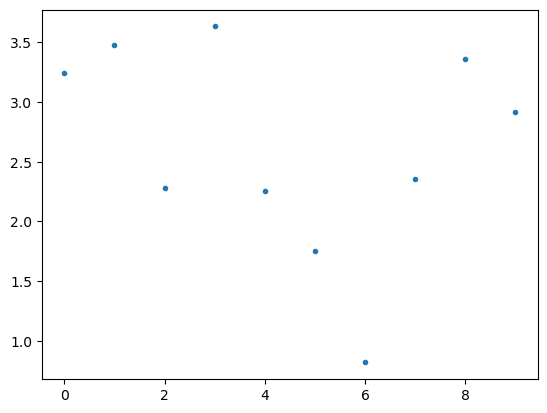

In [7]:
plt.plot(g,'.')

## compute and plot

### compute function

compute($\lambda s,P_0(x),g(x),g_{exp},\sigma_{exp},\alpha$): given
- some values for $\lambda$ variable (for example lambdas=np.arange(-lambdamax-dlambda,lambdamax+dlambda,dlambda))
- the reference ensemble $P_0(x)$
- the observable $g(x)$
- its experimental value $g_{exp}$ and error $\sigma_{exp}$
- the $\alpha$ hyperparameter

it returns

- the new probability distributions $P_\lambda(x)$
- the new partition functions $Z_\lambda$
- the average value of the observable $\langle g\rangle_\lambda$ (as a function of $\lambda$)
- the standard deviation of the observable $\sigma(\lambda)$ (which is the "volume transformation")
- the "volume transformation" for the Dirichlet prior
- the $\chi^2(\lambda)$
- the relative entropy $S[P_\lambda|P_0]$
- the values of loss function $\mathcal L(\lambda)$
- the values of Gamma function $\Gamma(\lambda)$


In [5]:
def compute(lambdas,P0,g,gexp,sigma,alpha):
    Zs=[]
    Ps=[]
    chi2=[]
    Srel=[]
    loss=[]
    av_gs=[]
    std_gs=[]
    dirichlets=[]

    for lambda_i in lambdas:
        P=P0*np.exp(-lambda_i*g)
        Z=np.sum(P)
        Zs.append(Z)
        P=P/Z
        Ps.append(P)

        av_g=np.dot(P,g)
        av_gs.append(av_g)

        av_g2=np.dot(P,g**2)
        std_gs.append(np.sqrt(av_g2-av_g**2))


        dirichlets.append(1/2*np.sqrt(np.abs(np.dot(P**2,(av_g*np.ones(len(P))-g)**2))))
        
        chi2.append(((av_g-gexp)/sigma)**2)
        #chi2.append((np.maximum(av_g-gexp,0)/sigma)**2)
        Srel.append(np.log(Z)+lambda_i*av_g)
        loss.append(1/2*chi2[-1]-alpha*Srel[-1])#1/2*av_g*av_g+alpha*(np.log(Z)+lambda_i*av_g))

    gamma=alpha*(np.log(Zs)+lambdas*gexp+1/2*alpha*(sigma*lambdas)**2)

    return Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma

### results

In [6]:
[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

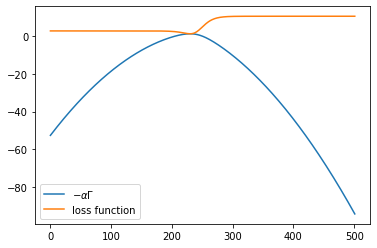

In [12]:
plt.plot(-gamma,label=r'$-\alpha\Gamma$')
plt.plot(loss,label='loss function')
plt.legend()

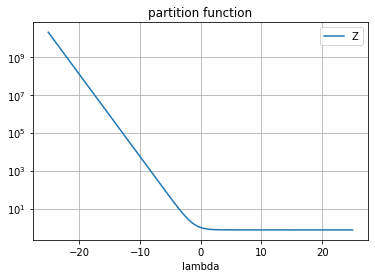

In [7]:
plt.plot(lambdas,Zs,'-',label='Z')
plt.yscale('log')
plt.xlabel('lambda')
plt.title('partition function')
plt.legend()
plt.grid()

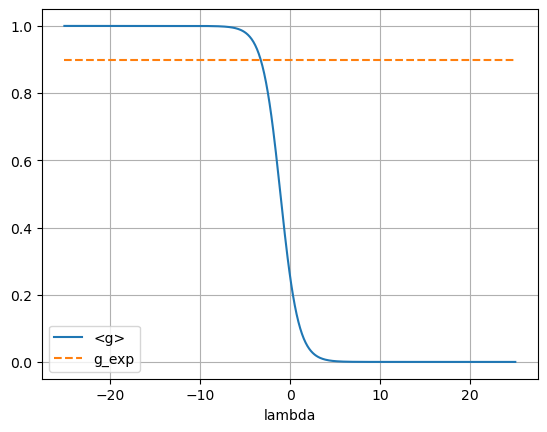

In [23]:
plt.plot(lambdas,av_gs,'-',label='<g>')
plt.plot([lambdas[0],lambdas[-1]],[gexp,gexp],'--',label='g_exp')
#plt.yscale('log')
plt.xlabel('lambda')
plt.legend()
plt.grid()

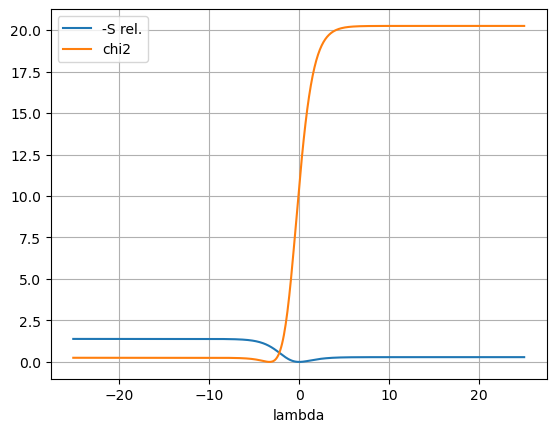

In [24]:
plt.plot(lambdas,-np.array(Srel),'-',label='-S rel.')
plt.plot(lambdas,chi2,'-',label='chi2')
plt.xlabel('lambda')
plt.legend()
plt.grid()


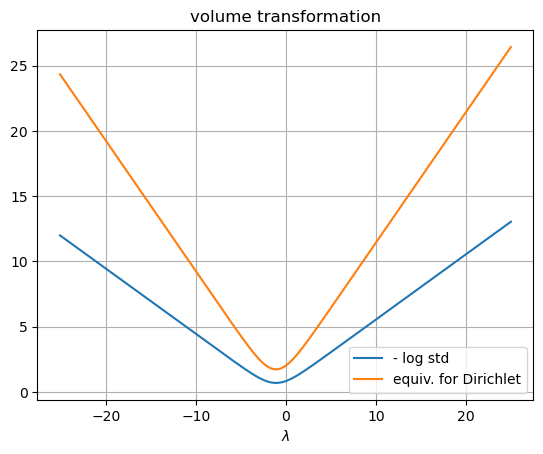

In [25]:
plt.plot(lambdas,-np.log(std_gs),'-',label='- log std')
plt.plot(lambdas,-np.log(dirichlets),'-',label='equiv. for Dirichlet')
plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
plt.title('volume transformation')
plt.show()

In [26]:
loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

delta=np.min(loss)-np.min(gamma)

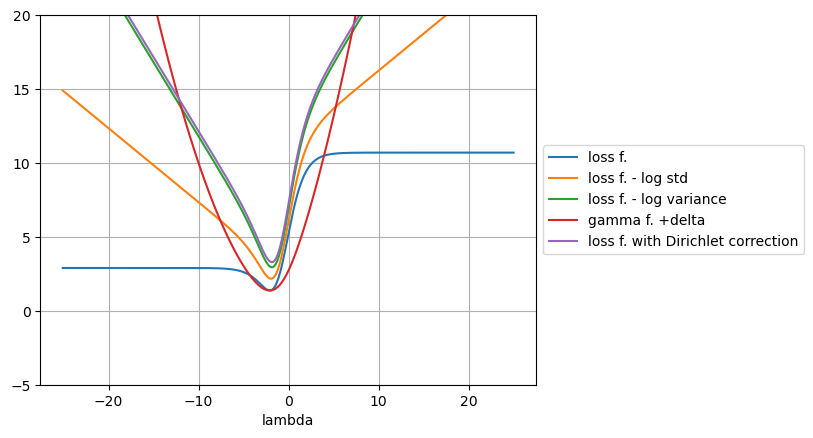

In [27]:
plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma+delta,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

In [28]:
xmin_loss=lambdas[np.argwhere(loss==np.min(loss))[0][0]]
xmin_gamma=lambdas[np.argwhere(gamma==np.min(gamma))[0][0]]
xmin_1=lambdas[np.argwhere(loss1==np.min(loss1))[0][0]]
xmin_2=lambdas[np.argwhere(loss2==np.min(loss2))[0][0]]

print('min. of the "original" loss function: ', xmin_loss)
print('min. of Gamma function: ',xmin_gamma)
print('min. of the loss f. with std correction: ', xmin_1)
print('min. of the loss f. with variance correction: ', xmin_2)


min. of the "original" loss function:  -2.0999999999996746
min. of Gamma function:  -2.0999999999996746
min. of the loss f. with std correction:  -1.9999999999996732
min. of the loss f. with variance correction:  -1.8999999999996717


so, the hyper probability distribution $P(\lambda)$ is:

In [29]:
P0=np.exp(-loss)
P1=np.exp(-loss1)
P2=np.exp(-loss2)
P_gamma=np.exp(-gamma)
P_dir=np.exp(-loss_dir)

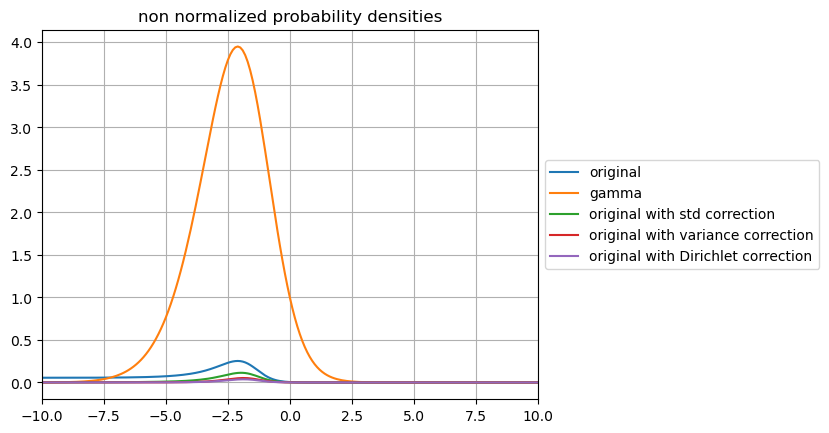

In [30]:
plt.plot(lambdas,P0,label='original')
plt.plot(lambdas,P_gamma,label='gamma')
plt.plot(lambdas,P1,label='original with std correction')
plt.plot(lambdas,P2,label='original with variance correction')
plt.plot(lambdas,P_dir,label='original with Dirichlet correction')
plt.xlim([-10,10])
#plt.yscale('log')
plt.grid()
plt.title('non normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
P0=P0/np.sum(P0)
P1=P1/np.sum(P1)
P2=P2/np.sum(P2)
P_gamma=P_gamma/np.sum(P_gamma)
P_dir=P_dir/np.sum(P_dir)

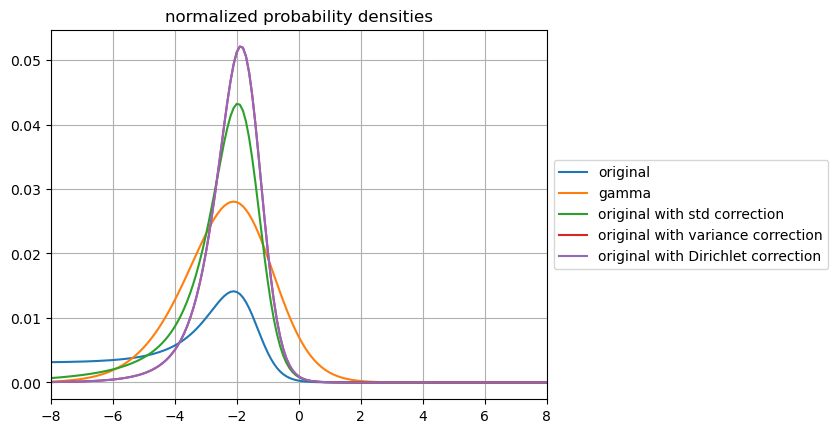

In [32]:
plt.plot(lambdas,P0,label='original')
plt.plot(lambdas,P_gamma,label='gamma')
plt.plot(lambdas,P1,label='original with std correction')
plt.plot(lambdas,P2,label='original with variance correction')
plt.plot(lambdas,P_dir,label='original with Dirichlet correction')
plt.xlim([-8,8])
#plt.yscale('log')
plt.grid()
plt.title('normalized probability densities')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

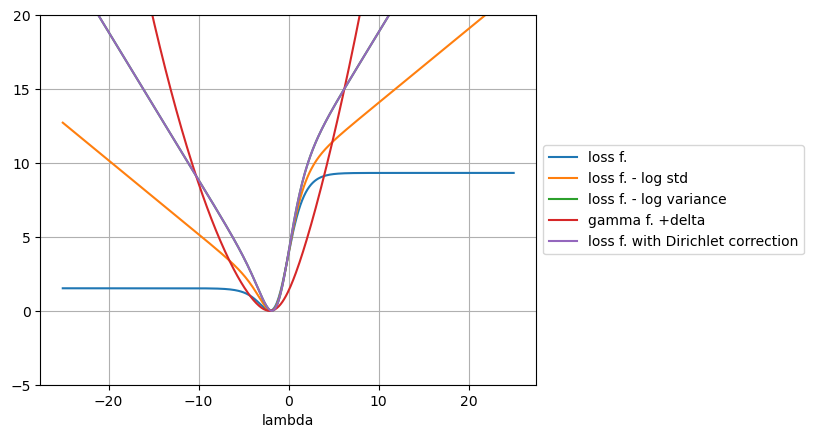

In [76]:
N=1
P0=np.array(
    [3.]*N + [1.]*N
)
P0/=np.sum(P0)
g=np.array(
    [0]*N + [1]*N
)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

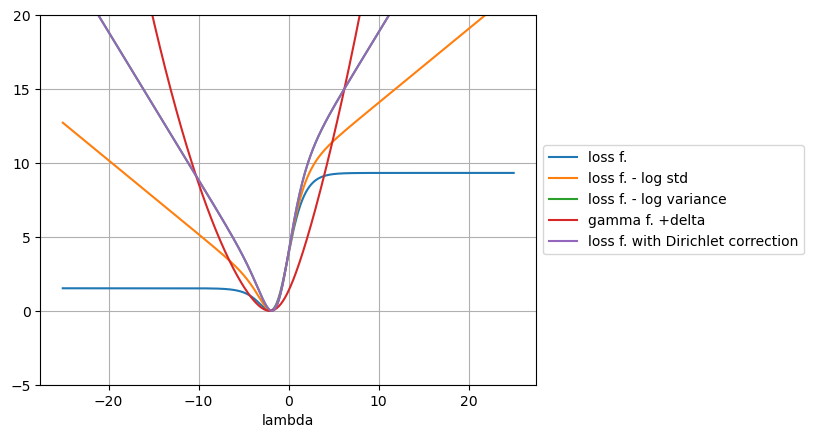

In [77]:
# invariance wrt number of frames:
N=1000
P0=np.array(
    [3.]*N + [1.]*N
)
P0/=np.sum(P0)
g=np.array(
    [0]*N + [1]*N
)

gexp=0.9



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

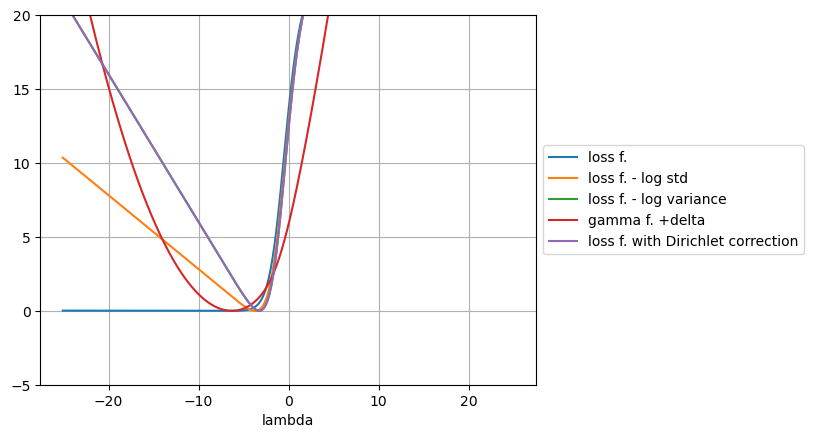

In [78]:
# data incompatible with trajectory
N=1
P0=np.array(
    [3.]*N + [1.]*N
)
P0/=np.sum(P0)
g=np.array(
    [0]*N + [1]*N
)

gexp=1.5



[Ps, Zs, av_gs, std_gs, dirichlets, chi2, Srel, loss, gamma]=compute(lambdas,P0,g,gexp,sigma,alpha)

loss=np.array(loss)
loss1=loss-np.log(std_gs)
loss2=loss-2*np.log(std_gs)
gamma=np.array(gamma)
loss_dir=loss-np.log(dirichlets)

loss-=np.min(loss)
loss1-=np.min(loss1)
loss2-=np.min(loss2)
gamma-=np.min(gamma)
loss_dir-=np.min(loss_dir)

plt.plot(lambdas,loss,'-',label='loss f.')#,markersize=0.5)
plt.plot(lambdas,loss1,'-',label='loss f. - log std')
plt.plot(lambdas,loss2,'-',label='loss f. - log variance')
#plt.plot(lambdas,gamma,'-',label='gamma f.')
plt.plot(lambdas,gamma,'-',label='gamma f. +delta')
plt.plot(lambdas,loss_dir,'-',label='loss f. with Dirichlet correction')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
#plt.yscale('log')
#plt.xlim([-10,10])
plt.ylim([-5,20])
plt.grid()

## Jeffreys uninformative prior

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x=np.arange(-2.5,3.5,0.001)
print(x.shape)

(6000,)


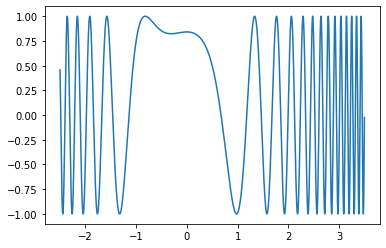

In [15]:
def fun_g(x):
    #return np.exp(-((x-1)**4-x**2+2*x))
    return np.sin(np.cos(x)**2-2*x**3)

g=fun_g(x)
plt.plot(x,g,'-')

In [16]:
def sampling(N,x,g,alph,N_sampling):
    where=np.linspace(0,x.shape[0]-1,N).astype(int)
    #print(where_1)
    x_sampling=x[where]
    g_sampling=fun_g(x_sampling)

    plt.plot(x,g)
    plt.plot(x_sampling,g_sampling,'.r',markersize=10)

    weights=np.random.dirichlet(alph*np.ones(N),N_sampling) # alpha = 1 or 1/2

    q_sampled=np.matmul(weights,g_sampling)**2 # the quantity you want to sample (average of g, variance of g...)

    return q_sampled

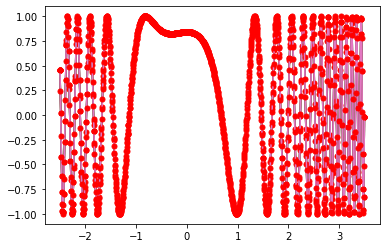

In [19]:
Ns=[10,20,50,100,200,500,1000]
alpha=1 # 1 or 1/2
N_sampling=10000

q_sampleds=[]
for N in Ns:
    q_sampleds.append(sampling(N,x,g,alpha,N_sampling))


[0.060586978663012735, 0.05997162750660942, 0.06951345723780923, 0.040752367866356935, 0.03288137594059137, 0.029754807233807055, 0.028326208782588843]


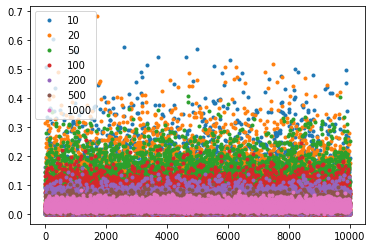

In [18]:
for i,N in enumerate(Ns):
    plt.plot(q_sampleds[i],'.',label=N)
plt.legend()

avs=[]
for i,N in enumerate(Ns):
    avs.append(np.mean(q_sampleds[i]))
print(avs)

[0.035119551464442435, 0.03455034785904569, 0.06174003385002132, 0.03570974105263024, 0.030370804362508837, 0.02867304443168695, 0.027922705999862227]


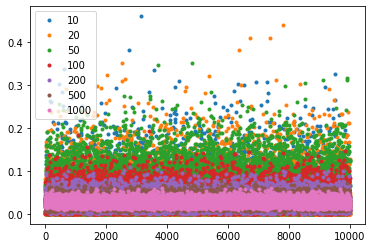

In [20]:
for i,N in enumerate(Ns):
    plt.plot(q_sampleds[i],'.',label=N)
plt.legend()

avs=[]
for i,N in enumerate(Ns):
    avs.append(np.mean(q_sampleds[i]))
print(avs)

## so, in the end doing Jeffreys prior is almost equivelent to alpha=1...?

In [6]:
plt.plot(avs_1,label='N1')
plt.plot(avs_2,label='N2')
plt.plot(avs_3,label='N2')
print(np.mean(avs_1),np.mean(avs_2),np.mean(avs_3))
plt.legend()

NameError: name 'avs_1' is not defined

0.026667435135400475 0.028265688649087642 0.028465574288292123


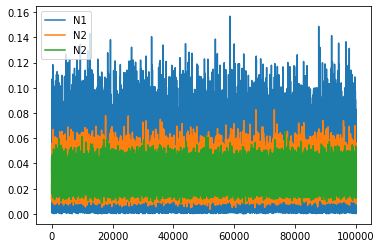

In [121]:
plt.plot(avs_1,label='N1')
plt.plot(avs_2,label='N2')
plt.plot(avs_3,label='N2')
print(np.mean(avs_1),np.mean(avs_2),np.mean(avs_3))
plt.legend()

0.15249940370065396 0.16590694702624353 0.16771715543179674


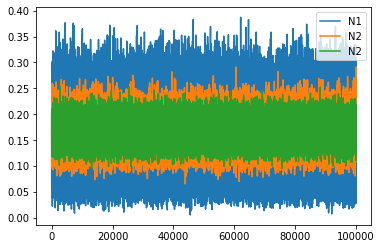

In [112]:
plt.plot(avs_1,label='N1')
plt.plot(avs_2,label='N2')
plt.plot(avs_3,label='N2')
print(np.mean(avs_1),np.mean(avs_2),np.mean(avs_3))
plt.legend()

0.152579936855169 0.1659328295028969 0.16757287422472472


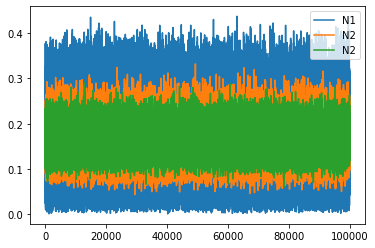

In [104]:
plt.plot(avs_1,label='N1')
plt.plot(avs_2,label='N2')
plt.plot(avs_3,label='N2')
print(np.mean(avs_1),np.mean(avs_2),np.mean(avs_3))
plt.legend()

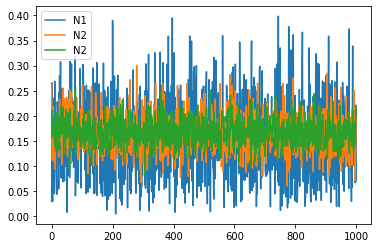

In [74]:
plt.plot(avs_1,label='N1')
plt.plot(avs_2,label='N2')
plt.plot(avs_3,label='N2')
plt.legend()